In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from ast import literal_eval

# Predicting Movie Revenue (Part 1: Box Office Prediction)
### DS 5110 - Group 6

**Introduction.** In today's fast-paced social life, more and more people will go to the cinema to watch movies to relax themselves. According to statistics, thousands of movies are released every year around the world, and the average production cycle of each movie takes more than two years. Therefore, whether each film can be profitable after its release is the most concerned issue of every film producer.

The main purpose of our project is to use the information in the existing movie database to mine the relationship between movie gross and other variables. We believe that the most judging indicator of a film's success in the film industry is its commercial value, so our project will predict what factors will affect the commercial value of a movie and how to maximize it.

**Problem Definition.** What are the effects of the different factors (other than the actors/casts, which is a separate problem investigated in another notebook) on the commercial value of a movie? For example, the genre, the duration, the release date, the keywords in the movie title, etc.

-----

## 1. The Data

The dataset is provided by MovieLens on <a href=https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset>Kaggle</a>. It consists of movies released on or before July 2017. Data points include cast, crew, plot keywords, budget, revenue, posters, release dates, languages, production companies, countries, TMDB vote counts and vote averages.

Let's first import the main movies metadata file (`movies_metadata.csv`) and take a quick look at the data:

In [2]:
df_movie = pd.read_csv("data/movies_metadata.csv")
df_movie.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [3]:
df_movie.shape

(45466, 24)

In [4]:
df_movie.dtypes

adult                     object
belongs_to_collection     object
budget                    object
genres                    object
homepage                  object
id                        object
imdb_id                   object
original_language         object
original_title            object
overview                  object
popularity                object
poster_path               object
production_companies      object
production_countries      object
release_date              object
revenue                  float64
runtime                  float64
spoken_languages          object
status                    object
tagline                   object
title                     object
video                     object
vote_average             float64
vote_count               float64
dtype: object

In [5]:
df_movie.describe()

,revenue,runtime,vote_average,vote_count
count,4.546000e+04,45203.000000,45460.000000,45460.000000
mean,1.120935e+07,94.128199,5.618207,109.897338
std,6.433225e+07,38.407810,1.924216,491.310374
min,0.000000e+00,0.000000,0.000000,0.000000
25%,0.000000e+00,85.000000,5.000000,3.000000
50%,0.000000e+00,95.000000,6.000000,10.000000
75%,0.000000e+00,107.000000,6.800000,34.000000
max,2.787965e+09,1256.000000,10.000000,14075.000000


We can see that there are 45,466 rows and 24 columns. Four of the columns (`revenue`, `runtime`, `vote_average`, and `vote_count`) are numeric, while others are objects. Specifically, at first glance, it seems that several columns contain *stringified JSON objects* (e.g. `genre`).

-----

## 2. Data Preprocessing

### 2.1 Missing Values

There are quite a lot of missing values in this dataset. Some of the columns even contain missing values up to 5 digits! 

After taking a closer look at the data, we decided to drop 6 columns that contain significant amounts of missing values *and* are not relevant in terms of our project goals. The columns to be dropped are: `belongs_to_collection`, `homepage`, `tagline`, `overview`, `poster_path`, and `imdb_id`.

In [6]:
df_movie.isna().sum()

adult                        0
belongs_to_collection    40972
budget                       0
genres                       0
homepage                 37684
id                           0
imdb_id                     17
original_language           11
original_title               0
overview                   954
popularity                   5
poster_path                386
production_companies         3
production_countries         3
release_date                87
revenue                      6
runtime                    263
spoken_languages             6
status                      87
tagline                  25054
title                        6
video                        6
vote_average                 6
vote_count                   6
dtype: int64

In [7]:
# Drop columns that contain many missing values and are not crucial for our project goals
df_movie = df_movie.drop(["belongs_to_collection",
                          "homepage",
                          "tagline",
                          "overview",
                          "poster_path",
                          "imdb_id"], axis=1)

df_movie.head()

,adult,budget,genres,id,original_language,original_title,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,title,video,vote_average,vote_count
0,False,30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,en,Toy Story,21.9469,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Toy Story,False,7.7,5415.0
1,False,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,en,Jumanji,17.0155,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Jumanji,False,6.9,2413.0
2,False,0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,en,Grumpier Old Men,11.7129,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Grumpier Old Men,False,6.5,92.0
3,False,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,en,Waiting to Exhale,3.85949,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Waiting to Exhale,False,6.1,34.0
4,False,0,"[{'id': 35, 'name': 'Comedy'}]",11862,en,Father of the Bride Part II,8.38752,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Father of the Bride Part II,False,5.7,173.0


In [8]:
df_movie.isna().sum()

adult                     0
budget                    0
genres                    0
id                        0
original_language        11
original_title            0
popularity                5
production_companies      3
production_countries      3
release_date             87
revenue                   6
runtime                 263
spoken_languages          6
status                   87
title                     6
video                     6
vote_average              6
vote_count                6
dtype: int64

As we can see, there are still some missing values. Let's first take a look at the `revenue` and `budget` columns as they may include missing values that are represented by both `NaN` and `0`.

### `revenue`

In [9]:
df_movie["revenue"]

0        373554033.0
1        262797249.0
2                0.0
3         81452156.0
4         76578911.0
            ...     
45461            0.0
45462            0.0
45463            0.0
45464            0.0
45465            0.0
Name: revenue, Length: 45466, dtype: float64

At first glance, there seems to be quite a lot of zeros in the `revenue` column. Based on the documentation, 0 means that the value is missing. Let's take a closer look at the number of 0s in the column:

In [10]:
print((df_movie["revenue"] == 0).sum())
print((sum(df_movie["revenue"] == 0) / df_movie.shape[0]) * 100, "%")

38052
83.69330928605991 %


We will select the subset of data where revenue data are available:

In [11]:
df_movie_revenue = df_movie
df_movie_revenue["revenue"] = df_movie_revenue["revenue"].replace(0, pd.np.nan)
df_movie_revenue = df_movie_revenue[df_movie_revenue['revenue'].notna()].reset_index(drop=True)
df_movie_revenue["revenue"].isnull().sum()

0

In [12]:
df_movie_revenue.shape

(7408, 18)

In [13]:
df_movie_revenue["revenue"].describe()

count    7.408000e+03
mean     6.878739e+07
std      1.464203e+08
min      1.000000e+00
25%      2.400000e+06
50%      1.682272e+07
75%      6.722707e+07
max      2.787965e+09
Name: revenue, dtype: float64

### `budget`

In [14]:
df_movie_revenue["budget"]

0       30000000
1       65000000
2       16000000
3              0
4       60000000
          ...   
7403      750000
7404           0
7405      800000
7406     2000000
7407     5000000
Name: budget, Length: 7408, dtype: object

In [15]:
df_movie_revenue["budget"].dtype

dtype('O')

In [16]:
df_movie_revenue["budget"] = df_movie_revenue["budget"].astype(int)

In [17]:
print(sum(df_movie_revenue["budget"] == 0))
print((sum(df_movie_revenue["budget"] == 0) / df_movie_revenue.shape[0]) * 100, "%")

2027
27.36231101511879 %


Again, we select the subset of data where budget data are available:

In [18]:
df_movie_revenue_budget = df_movie_revenue
df_movie_revenue_budget["budget"] = df_movie_revenue_budget["budget"].replace(0, pd.np.nan)
df_movie_revenue_budget = df_movie_revenue_budget[df_movie_revenue_budget['budget'].notna()].reset_index(drop=True)
df_movie_revenue_budget["budget"].isnull().sum()

0

In [19]:
df_movie_revenue_budget.shape

(5381, 18)

In [20]:
df_movie_revenue_budget["budget"].describe()

count    5.381000e+03
mean     3.109480e+07
std      4.016263e+07
min      1.000000e+00
25%      5.037000e+06
50%      1.700000e+07
75%      4.000000e+07
max      3.800000e+08
Name: budget, dtype: float64

-----

Now that we've taken care of missing values for revenue and budget, in our new `df_movie_revenue_budget` dataset, there remains one column (`runtime`) with one missing value. We will deal with it now:

In [21]:
df_movie_revenue_budget.isnull().sum()

adult                   0
budget                  0
genres                  0
id                      0
original_language       0
original_title          0
popularity              0
production_companies    0
production_countries    0
release_date            0
revenue                 0
runtime                 1
spoken_languages        0
status                  0
title                   0
video                   0
vote_average            0
vote_count              0
dtype: int64

In [22]:
df_movie_revenue_budget["runtime"]

0        81.0
1       104.0
2       127.0
3       170.0
4       106.0
        ...  
5376    185.0
5377      0.0
5378    100.0
5379    107.0
5380     91.0
Name: runtime, Length: 5381, dtype: float64

In [23]:
df_movie_revenue_budget["runtime"].fillna(df_movie_revenue_budget["runtime"].median(), inplace=True)
df_movie_revenue_budget["runtime"].isnull().sum()

0

------

As we can see, now our dataset contains no missing values:

In [24]:
df_movie_revenue_budget.isna().sum()

adult                   0
budget                  0
genres                  0
id                      0
original_language       0
original_title          0
popularity              0
production_companies    0
production_countries    0
release_date            0
revenue                 0
runtime                 0
spoken_languages        0
status                  0
title                   0
video                   0
vote_average            0
vote_count              0
dtype: int64

In [25]:
df_movie_revenue_budget.shape

(5381, 18)

-----

### 2.2 Transforming Columns

Some columns contain stringified JSON objects: `genres`, `production_companies`, `production_countries`, and `spoken_languages`. We need to transform them and create new columns for the values.

In [26]:
df_movie_revenue_budget.dtypes

adult                    object
budget                  float64
genres                   object
id                       object
original_language        object
original_title           object
popularity               object
production_companies     object
production_countries     object
release_date             object
revenue                 float64
runtime                 float64
spoken_languages         object
status                   object
title                    object
video                    object
vote_average            float64
vote_count              float64
dtype: object

In [27]:
df_movie_revenue_budget.head()

,adult,budget,genres,id,original_language,original_title,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,title,video,vote_average,vote_count
0,False,30000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,en,Toy Story,21.9469,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Toy Story,False,7.7,5415.0
1,False,65000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,en,Jumanji,17.0155,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Jumanji,False,6.9,2413.0
2,False,16000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,en,Waiting to Exhale,3.85949,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Waiting to Exhale,False,6.1,34.0
3,False,60000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",949,en,Heat,17.9249,"[{'name': 'Regency Enterprises', 'id': 508}, {...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,187436818.0,170.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Heat,False,7.7,1886.0
4,False,35000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",9091,en,Sudden Death,5.23158,"[{'name': 'Universal Pictures', 'id': 33}, {'n...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,64350171.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Sudden Death,False,5.5,174.0


### Genres

We will create a column for each genre:

In [28]:
df_movie_revenue_budget["genres"]

0       [{'id': 16, 'name': 'Animation'}, {'id': 35, '...
1       [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...
2       [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...
3       [{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...
4       [{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...
                              ...                        
5376    [{'id': 28, 'name': 'Action'}, {'id': 35, 'nam...
5377    [{'id': 80, 'name': 'Crime'}, {'id': 35, 'name...
5378    [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...
5379    [{'id': 10749, 'name': 'Romance'}, {'id': 18, ...
5380    [{'id': 28, 'name': 'Action'}, {'id': 35, 'nam...
Name: genres, Length: 5381, dtype: object

In [29]:
df_movie_revenue_budget["genres"].dtype

dtype('O')

In [30]:
uniqueGenres = set([])
for i in df_movie_revenue_budget.genres.values:
    genList = literal_eval(i) # convert from string to list of dict
    for j in genList: 
        uniqueGenres.add(j["name"]) 

print(len(uniqueGenres))
uniqueGenres

20


{'Action',
 'Adventure',
 'Animation',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'Foreign',
 'History',
 'Horror',
 'Music',
 'Mystery',
 'Romance',
 'Science Fiction',
 'TV Movie',
 'Thriller',
 'War',
 'Western'}

In [31]:
rows = [] # for all the movies
genres = list(uniqueGenres) # all unique Genres

for i in df_movie_revenue_budget.genres:
    genList = literal_eval(i) # convert from string to list of dict for a particular movie
    movieGenres = [x['name'] for x in genList] # list of all the genres of the movie
    row = [] # store a list of 1s and 0s for one movie
    
    for j in genres:
        # check if the genre is present in that movie - if the genre is present 1 else 0
        row.append(int(j in movieGenres))
    
    rows.append(row)

genre = pd.DataFrame(rows, columns=genres)
genre

,Comedy,Drama,Family,Crime,Action,Mystery,Science Fiction,Foreign,Western,TV Movie,Animation,Horror,History,Fantasy,Romance,Thriller,War,Documentary,Music,Adventure
0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5376,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5377,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5378,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5379,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [32]:
genre.shape

(5381, 20)

In [33]:
df_movie_revenue_budget.shape

(5381, 18)

In [34]:
# Join the genres df with our main df and drop the original genre column
df_movie_revenue_budget = pd.concat([df_movie_revenue_budget, genre], axis=1)
df_movie_revenue_budget.drop(["genres"], axis=1, inplace=True)
df_movie_revenue_budget.head()

,adult,budget,id,original_language,original_title,popularity,production_companies,production_countries,release_date,revenue,...,Animation,Horror,History,Fantasy,Romance,Thriller,War,Documentary,Music,Adventure
0,False,30000000.0,862,en,Toy Story,21.9469,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,...,1,0,0,0,0,0,0,0,0,0
1,False,65000000.0,8844,en,Jumanji,17.0155,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,...,0,0,0,1,0,0,0,0,0,1
2,False,16000000.0,31357,en,Waiting to Exhale,3.85949,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,...,0,0,0,0,1,0,0,0,0,0
3,False,60000000.0,949,en,Heat,17.9249,"[{'name': 'Regency Enterprises', 'id': 508}, {...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,187436818.0,...,0,0,0,0,0,1,0,0,0,0
4,False,35000000.0,9091,en,Sudden Death,5.23158,"[{'name': 'Universal Pictures', 'id': 33}, {'n...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,64350171.0,...,0,0,0,0,0,1,0,0,0,1


### Production Companies

We will extract the main producers and the counts and create new columns: `producer` and `producer_counts` to store them in our dataframe.

In [35]:
df_movie_revenue_budget["production_companies"]

0          [{'name': 'Pixar Animation Studios', 'id': 3}]
1       [{'name': 'TriStar Pictures', 'id': 559}, {'na...
2       [{'name': 'Twentieth Century Fox Film Corporat...
3       [{'name': 'Regency Enterprises', 'id': 508}, {...
4       [{'name': 'Universal Pictures', 'id': 33}, {'n...
                              ...                        
5376           [{'name': 'AVM Productions', 'id': 16424}]
5377    [{'name': 'Кинокомпания «Lunapark»', 'id': 420...
5378                                                   []
5379                    [{'name': 'Profit', 'id': 21163}]
5380                                                   []
Name: production_companies, Length: 5381, dtype: object

In [36]:
producers = [] # production company names for each movie
prod_counts = []

for producer in df_movie_revenue_budget.production_companies.values:
    prodList = literal_eval(producer)
    prod_counts.append(len(prodList))
    if len(prodList) > 0: # if the movie has at least 1 producer
        producers.append(prodList[0]["name"].strip())
    else:
        producers.append("No Producer")

df_movie_revenue_budget["producer"] = producers
df_movie_revenue_budget["producer_count"] = prod_counts
df_movie_revenue_budget.drop(["production_companies"], axis=1, inplace=True)
df_movie_revenue_budget.head()

,adult,budget,id,original_language,original_title,popularity,production_countries,release_date,revenue,runtime,...,History,Fantasy,Romance,Thriller,War,Documentary,Music,Adventure,producer,producer_count
0,False,30000000.0,862,en,Toy Story,21.9469,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,...,0,0,0,0,0,0,0,0,Pixar Animation Studios,1
1,False,65000000.0,8844,en,Jumanji,17.0155,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,...,0,1,0,0,0,0,0,1,TriStar Pictures,3
2,False,16000000.0,31357,en,Waiting to Exhale,3.85949,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,...,0,0,1,0,0,0,0,0,Twentieth Century Fox Film Corporation,1
3,False,60000000.0,949,en,Heat,17.9249,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,187436818.0,170.0,...,0,0,0,1,0,0,0,0,Regency Enterprises,3
4,False,35000000.0,9091,en,Sudden Death,5.23158,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,64350171.0,106.0,...,0,0,0,1,0,0,0,1,Universal Pictures,3


### Production Countries

Similarily, we will extract the production countries as well as the counts and store them in the new columns,  `production_country` and `production_countries_count`.

In [37]:
df_movie_revenue_budget["production_countries"]

0       [{'iso_3166_1': 'US', 'name': 'United States o...
1       [{'iso_3166_1': 'US', 'name': 'United States o...
2       [{'iso_3166_1': 'US', 'name': 'United States o...
3       [{'iso_3166_1': 'US', 'name': 'United States o...
4       [{'iso_3166_1': 'US', 'name': 'United States o...
                              ...                        
5376              [{'iso_3166_1': 'IN', 'name': 'India'}]
5377             [{'iso_3166_1': 'RU', 'name': 'Russia'}]
5378                                                   []
5379             [{'iso_3166_1': 'RU', 'name': 'Russia'}]
5380             [{'iso_3166_1': 'RU', 'name': 'Russia'}]
Name: production_countries, Length: 5381, dtype: object

In [38]:
prod_countries = []
prod_countries_counts = []

for country in df_movie_revenue_budget.production_countries.values:
    countryList = literal_eval(country)
    prod_countries_counts.append(len(countryList))
    if len(countryList) > 0:
        prod_countries.append(countryList[0]["name"].strip())
    else:
        prod_countries.append("N/A")

df_movie_revenue_budget["production_country"] = prod_countries
df_movie_revenue_budget["production_countries_count"] = prod_countries_counts
df_movie_revenue_budget.drop(["production_countries"], axis=1, inplace=True)
df_movie_revenue_budget.head()

,adult,budget,id,original_language,original_title,popularity,release_date,revenue,runtime,spoken_languages,...,Romance,Thriller,War,Documentary,Music,Adventure,producer,producer_count,production_country,production_countries_count
0,False,30000000.0,862,en,Toy Story,21.9469,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",...,0,0,0,0,0,0,Pixar Animation Studios,1,United States of America,1
1,False,65000000.0,8844,en,Jumanji,17.0155,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",...,0,0,0,0,0,1,TriStar Pictures,3,United States of America,1
2,False,16000000.0,31357,en,Waiting to Exhale,3.85949,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",...,1,0,0,0,0,0,Twentieth Century Fox Film Corporation,1,United States of America,1
3,False,60000000.0,949,en,Heat,17.9249,1995-12-15,187436818.0,170.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",...,0,1,0,0,0,0,Regency Enterprises,3,United States of America,1
4,False,35000000.0,9091,en,Sudden Death,5.23158,1995-12-22,64350171.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",...,0,1,0,0,0,1,Universal Pictures,3,United States of America,1


### Spoken Languages

Again, we will extract the main spoken language as well as the total number of languages used for each movie into `spoken_language` and `spoken_languages_count`.

In [39]:
df_movie_revenue_budget["spoken_languages"]

0                [{'iso_639_1': 'en', 'name': 'English'}]
1       [{'iso_639_1': 'en', 'name': 'English'}, {'iso...
2                [{'iso_639_1': 'en', 'name': 'English'}]
3       [{'iso_639_1': 'en', 'name': 'English'}, {'iso...
4                [{'iso_639_1': 'en', 'name': 'English'}]
                              ...                        
5376    [{'iso_639_1': 'ta', 'name': 'தமிழ்'}, {'iso_6...
5377             [{'iso_639_1': 'ru', 'name': 'Pусский'}]
5378             [{'iso_639_1': 'ru', 'name': 'Pусский'}]
5379             [{'iso_639_1': 'ru', 'name': 'Pусский'}]
5380             [{'iso_639_1': 'ru', 'name': 'Pусский'}]
Name: spoken_languages, Length: 5381, dtype: object

In [40]:
spoken_languages = []
language_counts = []

for languages in df_movie_revenue_budget.spoken_languages.values:
    langList = literal_eval(languages)
    language_counts.append(len(langList))
    if len(langList) > 0:
        spoken_languages.append(langList[0]["iso_639_1"].strip())
    else:
        spoken_languages.append("N/A")
        
df_movie_revenue_budget["spoken_langauge"] = spoken_languages
df_movie_revenue_budget["spoken_languages_count"] = language_counts
df_movie_revenue_budget.drop(["spoken_languages"], axis=1, inplace=True)
df_movie_revenue_budget.head()

,adult,budget,id,original_language,original_title,popularity,release_date,revenue,runtime,status,...,War,Documentary,Music,Adventure,producer,producer_count,production_country,production_countries_count,spoken_langauge,spoken_languages_count
0,False,30000000.0,862,en,Toy Story,21.9469,1995-10-30,373554033.0,81.0,Released,...,0,0,0,0,Pixar Animation Studios,1,United States of America,1,en,1
1,False,65000000.0,8844,en,Jumanji,17.0155,1995-12-15,262797249.0,104.0,Released,...,0,0,0,1,TriStar Pictures,3,United States of America,1,en,2
2,False,16000000.0,31357,en,Waiting to Exhale,3.85949,1995-12-22,81452156.0,127.0,Released,...,0,0,0,0,Twentieth Century Fox Film Corporation,1,United States of America,1,en,1
3,False,60000000.0,949,en,Heat,17.9249,1995-12-15,187436818.0,170.0,Released,...,0,0,0,0,Regency Enterprises,3,United States of America,1,en,2
4,False,35000000.0,9091,en,Sudden Death,5.23158,1995-12-22,64350171.0,106.0,Released,...,0,0,0,1,Universal Pictures,3,United States of America,1,en,1


### Release Date

Lastly, let's convert the `release_date` column to contain datetime objects and extract only the year into `release_year`.

In [41]:
df_movie_revenue_budget["release_date"].dtype

dtype('O')

In [42]:
df_movie_revenue_budget["release_date"] = pd.to_datetime(df_movie_revenue_budget["release_date"], format="%Y-%m-%d", errors='coerce')
df_movie_revenue_budget["release_year"] = df_movie_revenue_budget["release_date"].dt.year
df_movie_revenue_budget.drop(["release_date"], axis=1, inplace=True)
df_movie_revenue_budget["release_year"]

0       1995
1       1995
2       1995
3       1995
4       1995
        ... 
5376    2007
5377    2014
5378    2006
5379    2010
5380    2007
Name: release_year, Length: 5381, dtype: int64

------

Below is the final result:

In [43]:
df_movie_revenue_budget.head()

,adult,budget,id,original_language,original_title,popularity,revenue,runtime,status,title,...,Documentary,Music,Adventure,producer,producer_count,production_country,production_countries_count,spoken_langauge,spoken_languages_count,release_year
0,False,30000000.0,862,en,Toy Story,21.9469,373554033.0,81.0,Released,Toy Story,...,0,0,0,Pixar Animation Studios,1,United States of America,1,en,1,1995
1,False,65000000.0,8844,en,Jumanji,17.0155,262797249.0,104.0,Released,Jumanji,...,0,0,1,TriStar Pictures,3,United States of America,1,en,2,1995
2,False,16000000.0,31357,en,Waiting to Exhale,3.85949,81452156.0,127.0,Released,Waiting to Exhale,...,0,0,0,Twentieth Century Fox Film Corporation,1,United States of America,1,en,1,1995
3,False,60000000.0,949,en,Heat,17.9249,187436818.0,170.0,Released,Heat,...,0,0,0,Regency Enterprises,3,United States of America,1,en,2,1995
4,False,35000000.0,9091,en,Sudden Death,5.23158,64350171.0,106.0,Released,Sudden Death,...,0,0,1,Universal Pictures,3,United States of America,1,en,1,1995


In [44]:
df_movie_revenue_budget.dtypes

adult                          object
budget                        float64
id                             object
original_language              object
original_title                 object
popularity                     object
revenue                       float64
runtime                       float64
status                         object
title                          object
video                          object
vote_average                  float64
vote_count                    float64
Comedy                          int64
Drama                           int64
Family                          int64
Crime                           int64
Action                          int64
Mystery                         int64
Science Fiction                 int64
Foreign                         int64
Western                         int64
TV Movie                        int64
Animation                       int64
Horror                          int64
History                         int64
Fantasy     

In [45]:
df_movie_revenue_budget.to_csv("data/cleaned_data.csv", index=False)

-----

## 3. EDA and Visualizations

In this section, we will perform some EDA and visualizations on the dataset to see if we can find some interesting patterns or relationships. First, let's import our cleaned dataset (`cleaned_data.csv`).

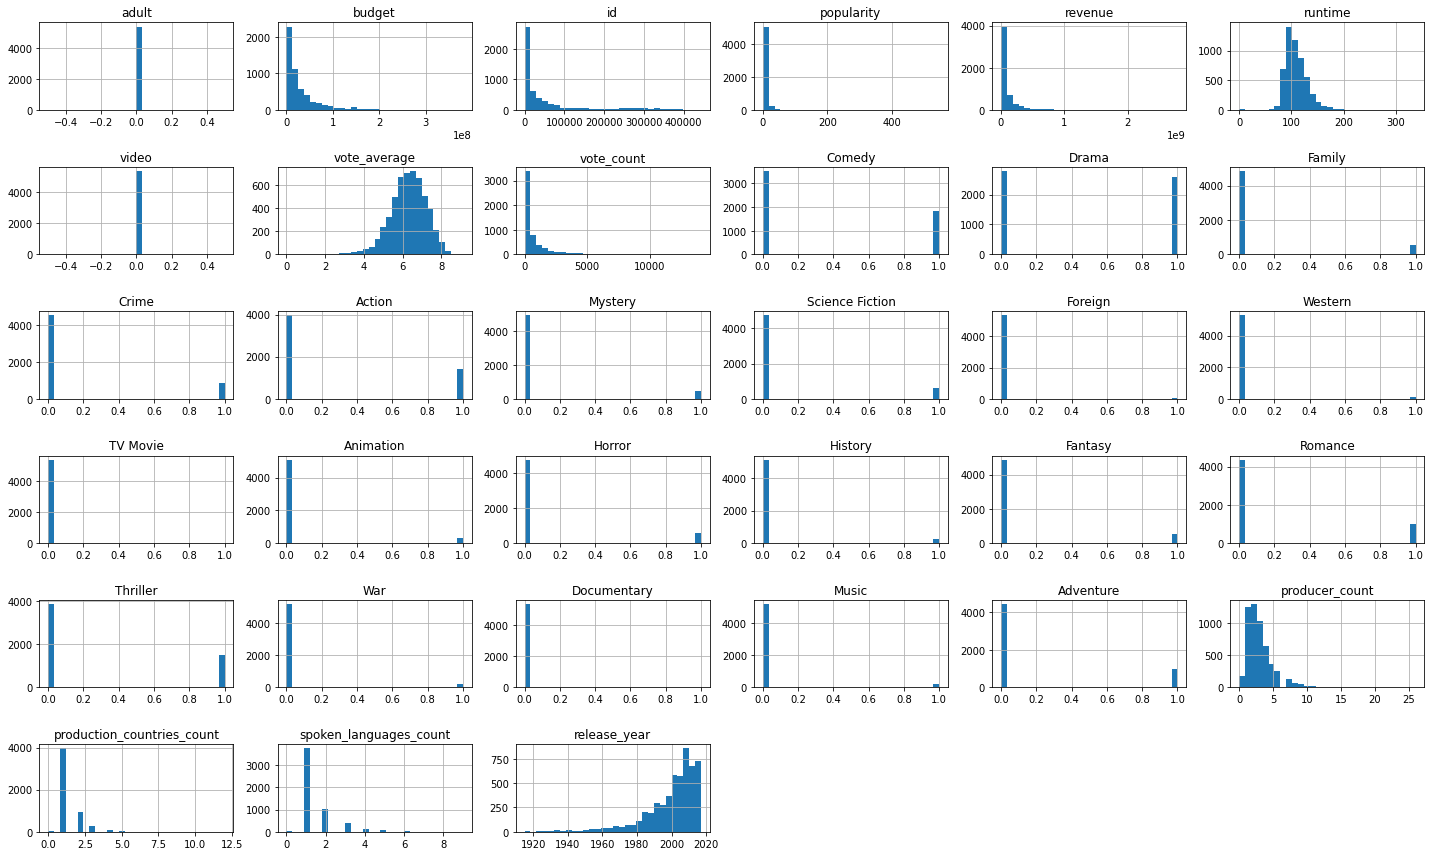

In [47]:
import seaborn as sns

movies = pd.read_csv("data/cleaned_data.csv")
movies.hist(bins=30,figsize=(20,12))
plt.tight_layout();

### 3.1 Top Revenue

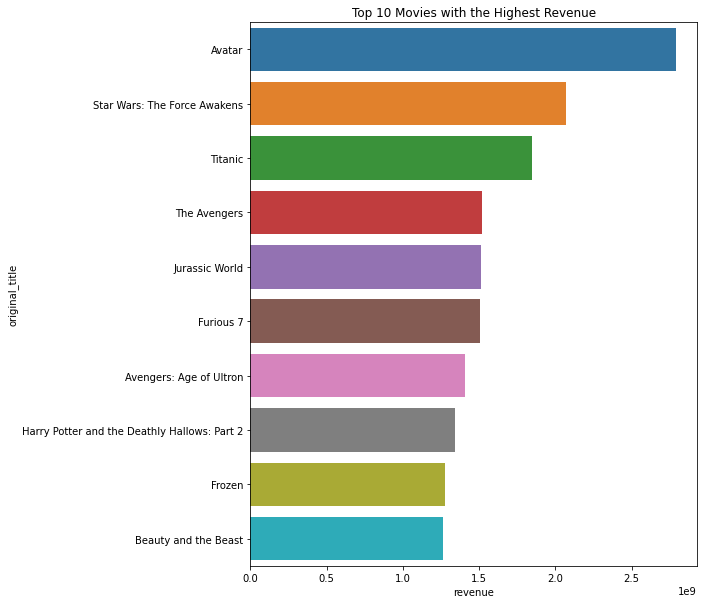

In [48]:
# Top 10 movies with the highest revenue
top_revenue = movies[["original_title", "revenue"]].sort_values("revenue", ascending=False).iloc[:10]

fig, axes = plt.subplots(figsize=(8, 10))
sns.barplot(y="original_title", x="revenue", data=top_revenue, orient="h")
plt.title("Top 10 Movies with the Highest Revenue");

As we can see, the highest earning movie is Avatar, with the total revenue being close to 3 billion! 

### 3.2 Top Budget

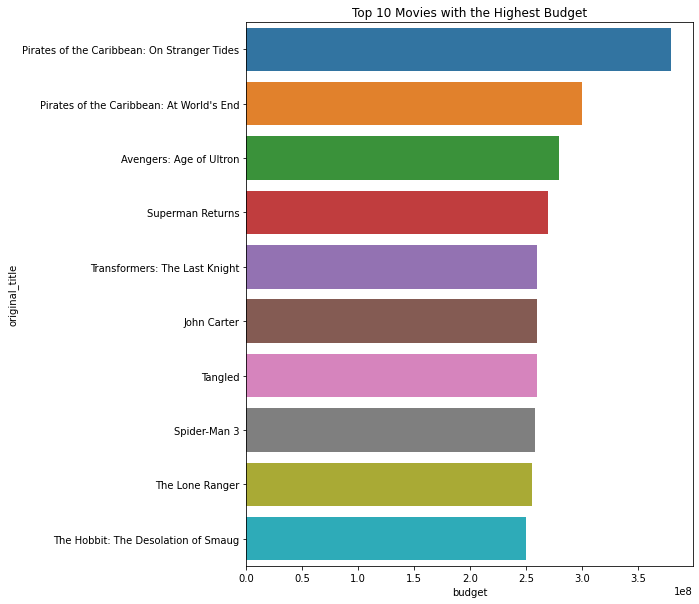

In [49]:
# Top 10 movies with the highest budget
top_budget = movies[["original_title", "budget"]].sort_values("budget", ascending=False).iloc[:10]

fig, axes = plt.subplots(figsize=(8, 10))
sns.barplot(y="original_title", x="budget", data=top_budget, orient="h")
plt.title("Top 10 Movies with the Highest Budget");

Two of the Pirates of the Caribbean movies ranked top 2 among all the movies in the dataset, followed by the Avengers, Superman Returns, and Transformers. It seems that movies with high revenue and high budgets are generally very famous and produced by well-known companies.

### 3.3 Top Profit

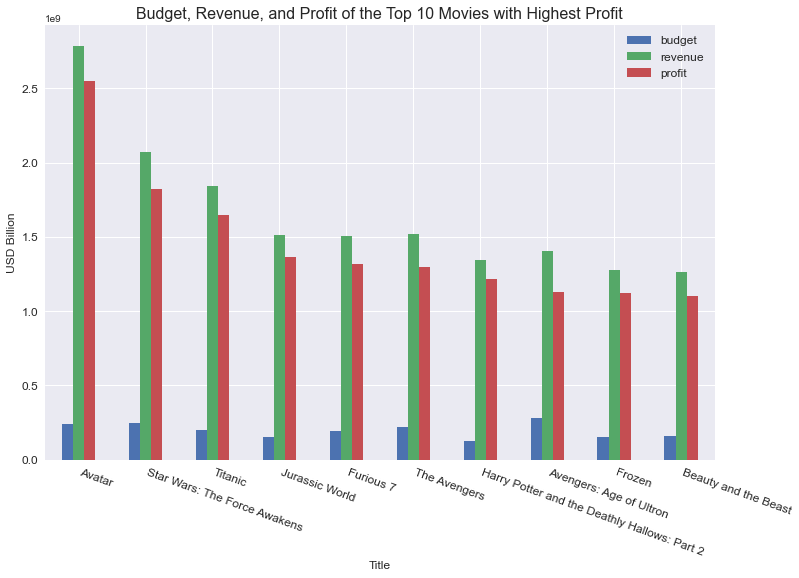

In [50]:
# Top 10 movies with the highest profit
top_profit = movies[["original_title", "revenue", "budget"]]
top_profit["profit"] = top_profit["revenue"] - top_profit["budget"]
top_profit = top_profit.sort_values("profit", ascending=False).iloc[:10]
top_profit.set_index("original_title", inplace=True)

plt.style.use('seaborn')
top_profit.iloc[:, [1, 0, 2]].plot(kind="bar", fontsize=12, figsize=(12, 8))
plt.title("Budget, Revenue, and Profit of the Top 10 Movies with Highest Profit", fontsize=16)
plt.xlabel("Title", fontsize=12)
plt.ylabel("USD Billion", fontsize=12)
plt.xticks(rotation=-20, ha="left")
plt.grid(True)
plt.axes().legend(fontsize=12);

Visually, we can see the huge gap between budget and profit in the ten most profitable movies.

### 3.4 Top Loss (i.e. Least Profit or "Box Office Bombs")

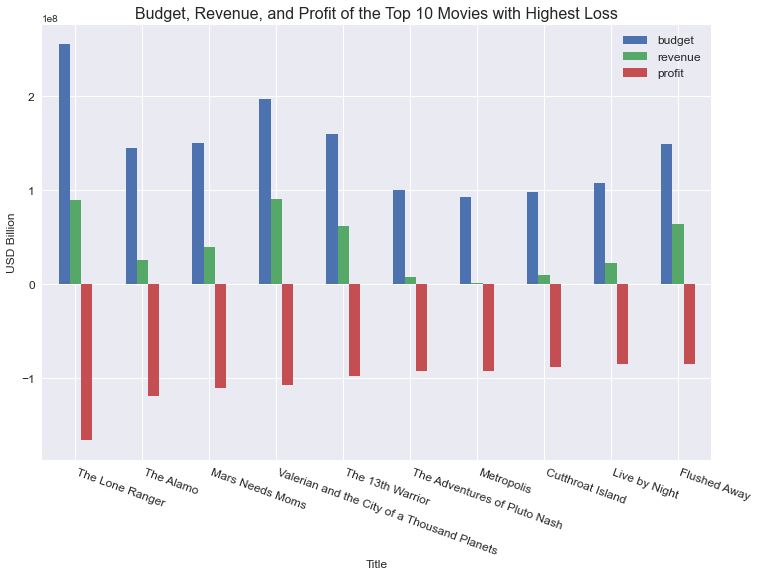

In [51]:
# Top 10 movies with highest loss
top_loss = movies[["original_title", "revenue", "budget"]]
top_loss["profit"] = top_loss["revenue"] - top_loss["budget"]
top_loss = top_loss.sort_values("profit").iloc[:10].set_index("original_title")

plt.style.use('seaborn')
top_loss.iloc[:, [1, 0, 2]].plot(kind="bar", fontsize=12, figsize=(12, 8))
plt.title("Budget, Revenue, and Profit of the Top 10 Movies with Highest Loss", fontsize=16)
plt.xlabel("Title", fontsize=12)
plt.ylabel("USD Billion", fontsize=12)
plt.xticks(rotation=-20, ha="left")
plt.axes().legend(fontsize=12);

It's quite surprising to see The Long Ranger ranked top 1 among "Box Office Bombs" since it's produced by Disney and stars Johnny Depp and Armie Hammer. One thing to notice is that, indeed, The Long Ranger did rank top 9 among movies with the highest budget, but it did not make the list of top 10 movies with the highest revenue.

### 3.5 Relationship with Revenue

### Budget

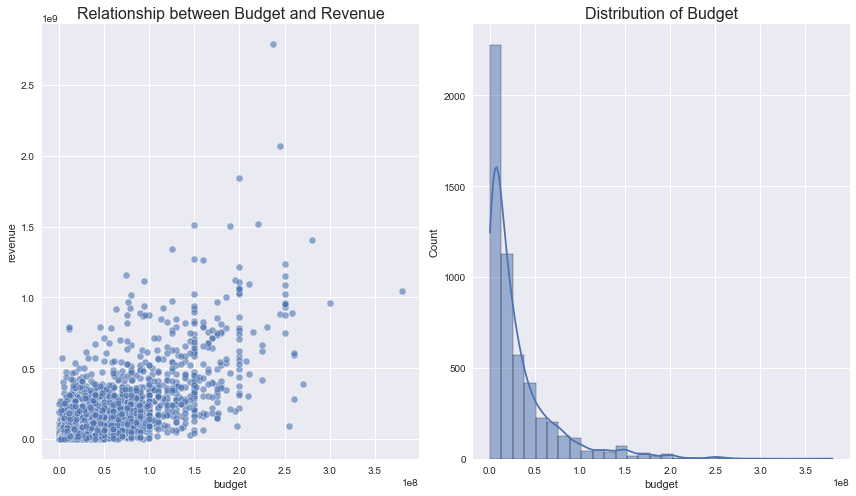

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(12, 7))

sns.scatterplot(x="budget", y="revenue", data=movies, alpha=.6, ax=axes[0])
sns.histplot(x="budget", data=movies, bins=30, kde=True, ax=axes[1])

axes[0].set_title("Relationship between Budget and Revenue", fontsize=16)
axes[1].set_title("Distribution of Budget", fontsize=16)
plt.tight_layout();

### Vote Average and Count

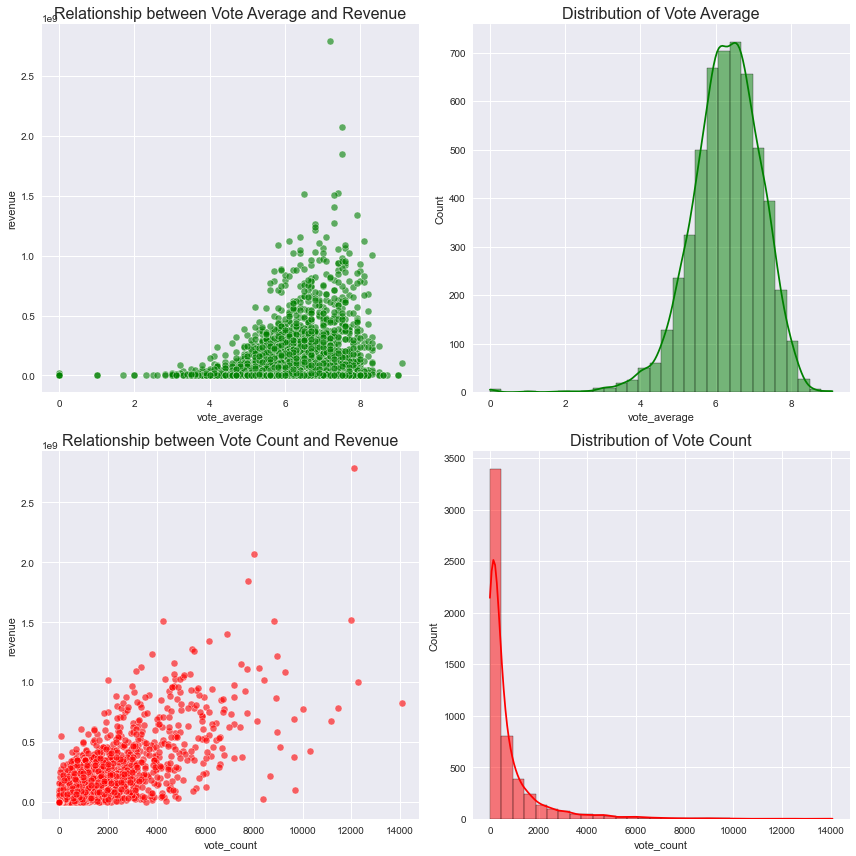

In [53]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

sns.scatterplot(x="vote_average", y="revenue", data=movies, alpha=.6, color='g', ax=axes[0, 0])
sns.histplot(x="vote_average", data=movies, bins=30, kde=True, color='g', ax=axes[0, 1])

sns.scatterplot(x="vote_count", y="revenue", data=movies, alpha=.6, color='r', ax=axes[1, 0])
sns.histplot(x="vote_count", data=movies, bins=30, kde=True, color='r', ax=axes[1, 1])

axes[0, 0].set_title("Relationship between Vote Average and Revenue", fontsize=16)
axes[0, 1].set_title("Distribution of Vote Average", fontsize=16)
axes[1, 0].set_title("Relationship between Vote Count and Revenue", fontsize=16)
axes[1, 1].set_title("Distribution of Vote Count", fontsize=16)
plt.tight_layout();

### Number of Production Companies

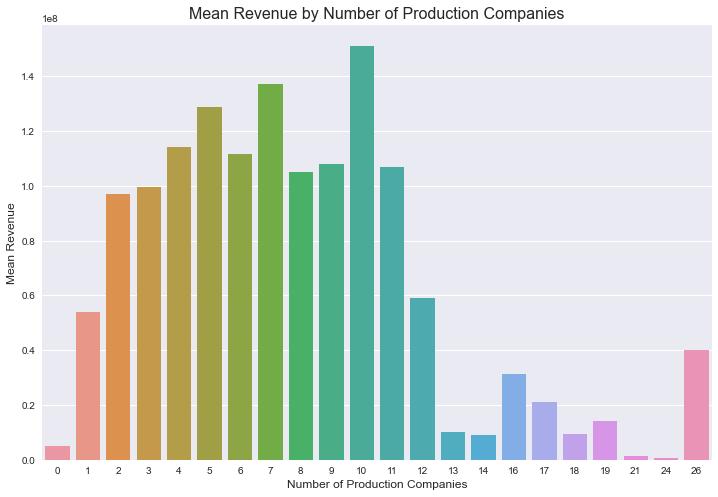

In [54]:
by_producer_cnt = movies.groupby("producer_count")["revenue"].mean().reset_index()
fig, axes = plt.subplots(figsize=(12, 8))
sns.barplot(x="producer_count", y="revenue", data=by_producer_cnt)
plt.title("Mean Revenue by Number of Production Companies", fontsize=16)
plt.xlabel("Number of Production Companies", fontsize=12)
plt.ylabel("Mean Revenue", fontsize=12);

### Original Language

In [55]:
by_language = movies.groupby("original_language")["revenue"].mean().sort_values(ascending=False)
by_language

original_language
en    9.809202e+07
zh    9.593801e+07
ja    5.657803e+07
te    4.911552e+07
xx    4.263028e+07
cn    3.541857e+07
ko    2.754810e+07
da    2.657762e+07
sv    2.641438e+07
hi    2.496719e+07
fr    2.441932e+07
de    2.228060e+07
es    2.140429e+07
ta    1.928846e+07
th    1.805112e+07
it    1.643443e+07
pt    1.384551e+07
ru    1.018975e+07
af    9.879971e+06
pl    9.737355e+06
nl    9.063913e+06
el    8.000000e+06
no    6.945288e+06
he    5.398014e+06
tr    4.823650e+06
mr    4.400000e+06
nb    4.159678e+06
ca    3.770657e+06
ml    3.622777e+06
id    2.392324e+06
fi    1.519627e+06
ur    1.452290e+06
hu    1.029700e+06
fa    9.000000e+05
vi    6.390000e+05
ro    4.206988e+05
kn    1.700000e+05
sr    1.453993e+05
bm    1.110000e+05
is    1.100000e+01
Name: revenue, dtype: float64

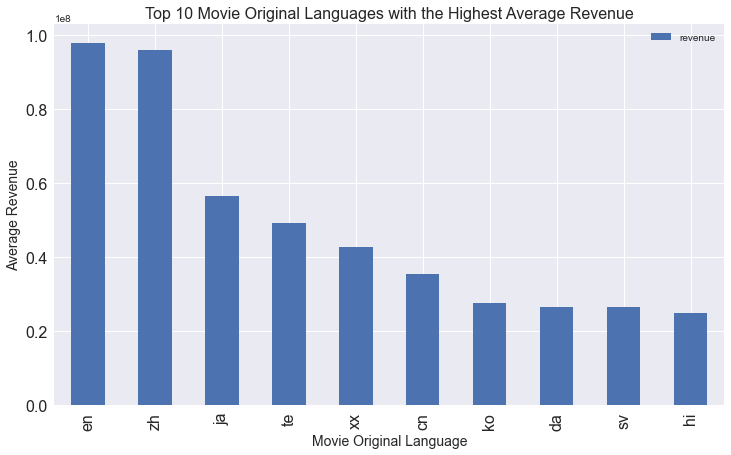

In [56]:
by_language = by_language.reset_index()
by_language.sort_values("revenue", ascending=False, inplace=True)
by_language.set_index("original_language", inplace=True)

by_language.iloc[:10].plot(kind="bar", figsize=(12, 7), fontsize=16)
plt.title("Top 10 Movie Original Languages with the Highest Average Revenue", fontsize=16)
plt.xlabel("Movie Original Language", fontsize=14)
plt.ylabel("Average Revenue", fontsize=14)
plt.tight_layout;

### 3.6 Correlations

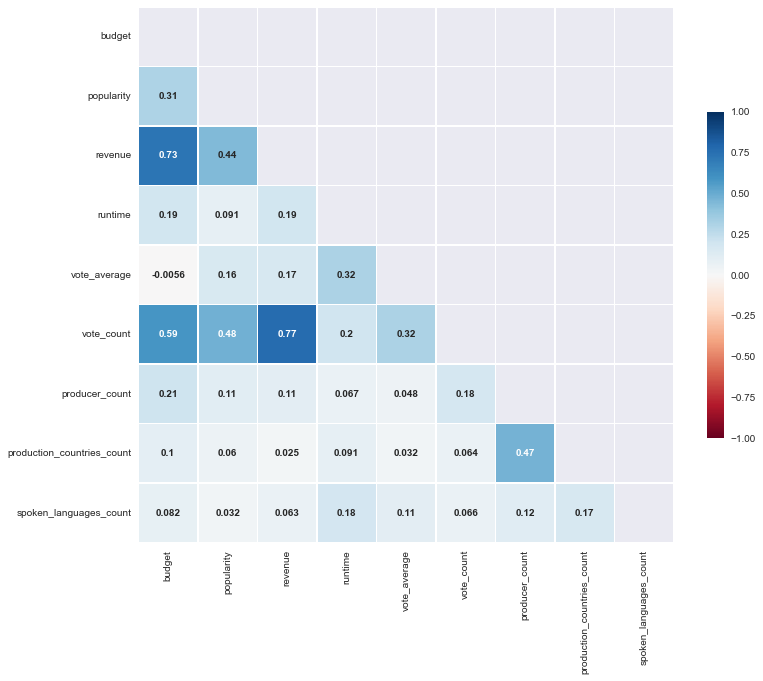

In [57]:
corr = movies.select_dtypes(include=['float64', 'int64'])[["budget",
                                                           "popularity",
                                                           "revenue",
                                                           "runtime",
                                                           "vote_average",
                                                           "vote_count",
                                                           "producer_count",
                                                           "production_countries_count",
                                                           "spoken_languages_count"]].corr()

fig, ax= plt.subplots(figsize=(12, 12))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask, annot=True, square=True, linewidths=.5, cmap='RdBu', vmin=-1, vmax=1,
            cbar_kws={'shrink': .5,}, annot_kws={'fontweight': 'bold'});

From the plots above, we can summarize that:
- Most features have right-skewed distributions due to the large number of 0s or small numbers, except for `vote_average` which looks somewhat like a normal distribution centered around 6.
- Revenue seems to be positively associated with **budget** and **vote count**.
- Among our dataset, movies with a total of 10 production companies have the highest average revenue.
- English and Chinese are the top languages in terms of movie revenue.


-----

## 4. Modeling

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor

In [59]:
# Dropping variables that will not be used in the model
movies.drop(columns=["title", "original_title", "id"], inplace=True)

### 4.1 Train Test Split

We will be using 20% of the available data as the testing set and the remaining data as the training set.

In [60]:
# Split data into X and y
y = movies["revenue"]
X = movies.drop(columns=["revenue"])

# Split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 4.2 One Hot Encoding

Let's use OneHotEncoder for the non-numeric columns `adult`, `original_language`, `status`, `video`, `producer`, `production_country`, `spoken_langauge`, `release_year`.

In [61]:
categorical_columns = ["adult",
                       "original_language",
                       "status",
                       "video",
                       "producer",
                       "production_country",
                       "spoken_langauge",
                       "release_year"]

ohe = OneHotEncoder(drop="if_binary", max_categories=10, handle_unknown="infrequent_if_exist").fit(X_train[categorical_columns])

# Transform categorical columns into one hot encoding and concatenate with non-categorical columns for training data
X_train_categorical = ohe.transform(X_train[categorical_columns]).toarray()
X_train.drop(columns=categorical_columns, inplace=True)
all_columns = list(X_train.columns) + list(ohe.get_feature_names_out(categorical_columns))
X_train = np.concatenate([X_train.to_numpy(), X_train_categorical], axis=1)

In [62]:
# Apply the same transformation for test data
X_test_categorical = ohe.transform(X_test[categorical_columns]).toarray()
X_test.drop(columns=categorical_columns, inplace=True)
X_test = np.concatenate([X_test.to_numpy(), X_test_categorical], axis=1)

### 4.3 Linear Regression

In [63]:
# Fit a linear regression model
lr = LinearRegression().fit(X_train, y_train)
print(lr.score(X_test, y_test))
print(lr.coef_)
print(lr.intercept_)

0.682503812307261
[ 1.76640999e+00  9.95711673e+05  1.78168195e+05 -2.30726217e+06
  6.90800156e+04  1.54240936e+06 -1.02089870e+07  1.95230122e+07
 -1.03136241e+07 -5.78473037e+06 -5.48043755e+06 -3.29189186e+07
 -4.93250166e+06 -2.75859248e+07  8.37809639e+07  1.82099508e+07
  9.97391954e+06 -1.05346205e+07 -4.26446765e+06  1.36086007e+07
 -3.28883148e+06 -9.82875728e+06  1.88244792e+07  9.91253334e+06
  1.62713229e+07 -4.02736251e+06 -2.85660394e+06  2.08643872e+06
 -2.23517418e-08 -1.27635153e+07  7.52318747e+06  8.50944860e+06
 -1.34751078e+07 -1.75915279e+07 -4.40566387e+07 -1.13483433e+06
  1.23535712e+07  5.03080544e+07  1.03273623e+07  1.40729187e+07
 -8.05723524e+06 -6.01568343e+06 -1.49011612e-08 -1.86908012e+07
 -1.89627400e+07 -5.91856021e+05 -2.01077054e+06  3.42007008e+06
  4.46391266e+06  1.25319443e+07  2.26893117e+06  1.71707899e+07
  4.00519591e+05 -2.69676124e+07 -1.18522395e+07 -7.95414266e+06
 -2.95207444e+07  1.14427610e+06  6.53337721e+07  1.48480377e+07
  2.181

In [64]:
from sklearn.metrics import mean_squared_error
y_pred = lr.predict(X=X_test)
rmse_lr = mean_squared_error(y_pred, y_test)**0.5
print("RMSE =", rmse_lr)

RMSE = 78026792.68431485


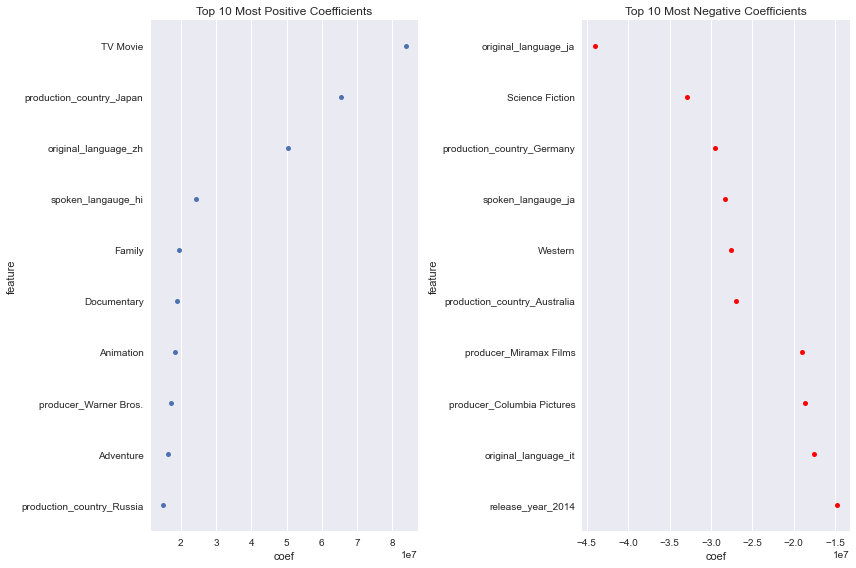

In [65]:
# What are the most positive and most negative coefficients?
coef_df = pd.DataFrame({"feature": all_columns, "coef": lr.coef_})
coef_df_pos = coef_df.sort_values("coef", ascending=False).iloc[:10, :]
coef_df_neg = coef_df.sort_values("coef").iloc[:10, :]

fig, axes = plt.subplots(1, 2, figsize=(12, 8))

sns.stripplot(y="feature", x="coef", data=coef_df_pos, orient="h", ax=axes[0])
sns.stripplot(y="feature", x="coef", data=coef_df_neg, orient="h", color="r", ax=axes[1])
axes[0].set_title("Top 10 Most Positive Coefficients")
axes[1].set_title("Top 10 Most Negative Coefficients")
plt.tight_layout();

The overall performance of the Linear Regression model is not that good, with an $R^2$ of 0.68 and RMSE of 78026792.68.

### 4.4 Random Forest

In [66]:
# Fit a random forest model
rf = RandomForestRegressor().fit(X_train, y_train)
print(rf.score(X_test, y_test))
print(rf.feature_importances_)

0.7373450066018219
[2.52100673e-01 3.24811276e-02 2.63202657e-02 2.05832298e-02
 5.53217380e-01 2.29841062e-03 2.50455959e-03 7.00898282e-03
 1.54606006e-03 2.84102666e-03 8.17349313e-04 3.84461864e-03
 2.26804703e-07 3.56075473e-04 6.30860528e-06 5.60870042e-03
 4.24270245e-04 2.17740706e-04 5.58820995e-03 4.43992364e-03
 2.47893171e-03 3.90185928e-04 4.71015732e-05 1.29199637e-03
 5.30729679e-03 1.64486533e-02 2.99982281e-03 5.40336640e-03
 0.00000000e+00 1.82619240e-04 8.26440783e-06 7.03063537e-05
 2.53056686e-05 4.83784211e-06 4.94667729e-05 3.50569336e-06
 3.36093373e-05 7.17918051e-04 8.15001542e-05 2.83707205e-09
 3.15143051e-07 4.62194179e-07 0.00000000e+00 8.24255389e-04
 3.17724582e-04 6.82778637e-04 4.61848772e-06 1.81640813e-03
 1.51879219e-03 2.67581274e-03 1.69617180e-03 1.41831924e-03
 3.15800709e-03 8.40402272e-04 2.76560610e-04 3.41476576e-04
 6.45308094e-04 4.08240986e-04 8.73331682e-04 4.26281875e-06
 1.92787030e-03 2.53589357e-03 5.79773488e-04 1.03879786e-04
 4.54

In [67]:
y_pred = rf.predict(X=X_test)
rmse_rf = mean_squared_error(y_pred, y_test)**0.5
print("RMSE =", rmse_rf)

RMSE = 70968778.26478662


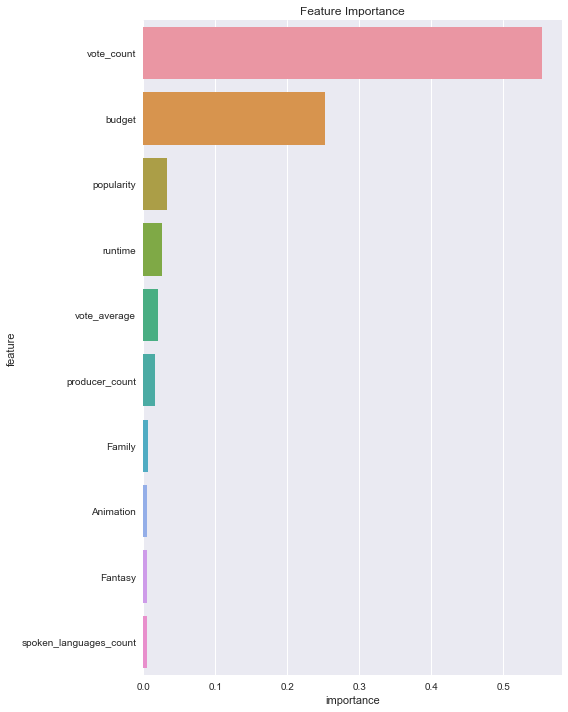

In [68]:
# What features are the most important?
feature_importance_df = pd.DataFrame({"feature": all_columns, "importance": rf.feature_importances_})
feature_importance_df = feature_importance_df.sort_values("importance", ascending=False).iloc[:10, :]

fig, axes = plt.subplots(figsize=(8, 10))
sns.barplot(y="feature", x="importance", data=feature_importance_df, orient="h")
plt.title("Feature Importance")
plt.tight_layout();

As we can see, the RMSE decreased and this model performed better than the previous Linear Regression model. We can also see that, based on the model, **vote count** is the most important factor in determining movie revenue, followed by **budget**, **popularity**, **runtime**, and **vote average**.

-----

## 5. Conclusion

**Results.** The performance of both models are summarized below. Overall, Random Forest performs better than Linear Regression, with a higher score and a lower RMSE. We can see that about 74% of the variation in movie revenues can be explanied by the Random Forest model.

In [69]:
rmse = [rmse_lr, rmse_rf]
score = [lr.score(X_test, y_test), rf.score(X_test, y_test)]
result_df = pd.DataFrame({"Model": ["Linear Regression", "Random Forest"], "RMSE": rmse, "Score": score})
result_df.set_index("Model")

,RMSE,Score
Model,,
Linear Regression,7.802679e+07,0.682504
Random Forest,7.096878e+07,0.737345


**Feature Importance.** Based on our Random Forest model, the top 5 importance features that are more closely related with movie revenue and contribute more for variation of the revenue are: `vote_count`, `budget`, `popularity`, `runtime`, `vote_average`. It seems reasonable that these features are important in determining the revenue of a movie!

Although we cannot be sure in which direction each of these features affect movie revenue, some intuitive interpretations / guesses on the relationships could be made. For example, we would expect movies with higher vote counts and higher popularity ratings to have higher revenue. Additionally, high-budget movies are typically produced / invested by well-known big companies and thus tend to yield higher revenues. 

On the other hand, for some features, the direction of effect remains ambiguous. Does longer runtime leads to higher revenue? Does more production companies associated with the movie leads to higher earnings? Are genres such as Family, Adventure, Fantasy, Animation postively or negatively associated with revenue? Unfortunately, these are questions that we are unable to answer at this point. All we know is that they *do* have some sort of effect on movie revenue.